# Final project -- Numerical Analysis -- 2020/2021


## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange 
from scipy.integrate import quad
from scipy.integrate import dblquad
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def Cheb_spectral_basis(n, i):
  '''
  IN:
    n: number of interpolating points
    i: index of the basis
  OUT:
    Cheb spectral basis function corresponding to i and its derivative
  '''
  X = np.polynomial.chebyshev.chebpts2(n)
  
  e_i = np.zeros((n,))
  e_i[i] = 1            # all zero except 1 in position corresponding to i

  B_i = lagrange(X, e_i)
  B_i_prime = np.polyder(B_i)

  return  B_i, B_i_prime


def compute_one_dimensional_matrices(n): 
    nq = n
    X = np.polynomial.chebyshev.chebpts2(n)     
    q, w = np.polynomial.legendre.leggauss(nq)  

    # Computation of matrices B and B_prime
    B = np.zeros((n,nq))
    B_prime = np.zeros((n,nq))

    for i in range(n):
      basis, basis_prime = Cheb_spectral_basis(n,i)
      for a in range(nq):
        B[i][a] = basis(q[a])
        B_prime[i][a] = basis_prime(q[a])
    
    # Computation of  K, M, A
    K = np.einsum('iq, q, jq', B_prime, w, B_prime)
    M = np.einsum('iq, q, jq', B, w, B)
    A = K + M
    
    return K, M, A

### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [ ]:
def exact_one_d(x):
  return np.cos(np.pi*x)
    
def rhs_one_d(x):
  return (np.pi**2)*np.cos(np.pi*x) + np.cos(np.pi*x)

def compute_error_one_d(exact, approx):
  return np.sqrt(np.sum(np.power(exact - approx,2)))

def Compute_F(n):
  F = np.zeros((n))

  for i in range(n):
    basis, basis_prime = Cheb_spectral_basis(n,i)
    integrand = lambda X: rhs_one_d(X)*basis(X)
    F[i] = quad(integrand, -1,1)[0]

  return F

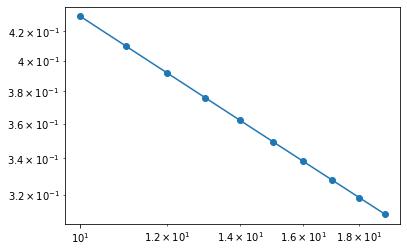

In [ ]:
error = []
all_n = range(10,20)
for n in all_n:
  q, w = np.polynomial.legendre.leggauss(n)

  K,M,A = compute_one_dimensional_matrices(n)

  F = Compute_F(n)

  u_fem = np.linalg.solve(A, F)

  error.append(compute_error_one_d(u_fem, exact_one_d(q)))

plt.loglog(all_n, error, 'o-')

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [ ]:
def compute_two_dimensional_matrices(n):

  K,M,A = compute_one_dimensional_matrices(n)

  KM = einsum('ik, jl -> ijkl', K, M)
  MK = einsum('ik, jl -> ijkl', M, K)
  MM = einsum('ik, jl -> ijkl', M, M)
  KK = KM+MK
  AA = KK+MM

  return AA, M, K

### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

![exact_2d.png](attachment:exact_2d.png)

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

In [ ]:
def exact_two_d(x,y):
  return np.cos(np.pi*x)*np.cos(np.pi*y)
    
def rhs_two_d(x,y):
  return (2*np.pi**2)*np.cos(np.pi*x)*np.cos(np.pi*y) + np.cos(np.pi*x)*np.cos(np.pi*y)

def compute_error_two_d(exact, approx):
  return np.sqrt(np.sum(np.power(exact-approx,2)))

def F_two_d(n):
  FF = np.zeros((n,n))

  for i in range(n):
    basis_i, basis_i_prime = Cheb_spectral_basis(n,i)
    for j in range(n):
      basis_j, basis_j_prime = Cheb_spectral_basis(n,j)

      integrand = lambda Y,X: rhs_two_d(X,Y)*basis_i(X)*basis_j(Y)
      FF[i][j] = dblquad(integrand, -1, 1, lambda x: -1, lambda x: 1)[0]

  return FF

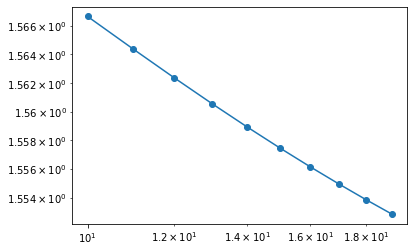

In [ ]:
error = []
all_n = range(10,20)

for n in all_n:
  q, w = np.polynomial.legendre.leggauss(n)

  AA, M, K = compute_two_dimensional_matrices(n)
  AA = AA.reshape((n**2, n**2))

  FF = F_two_d(n)
  FF = FF.reshape(n**2)

  u_2d_fem = np.linalg.solve(AA, FF)
  
  exact_2d = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      exact_2d[i][j] = exact_two_d(q[i],q[j])

  exact_2d = exact_2d.reshape(n*n)

  error.append(compute_error_two_d(u_2d_fem, exact_2d))


plt.loglog(all_n, error, 'o-')

### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [ ]:
def matvec_1(src):
  return AA.dot(src)
 

def cg(matvec, b, x, tol=1e-05, maxiter=10000):
  r = b - matvec(x)
  if np.linalg.norm(r,2) < tol:
    return x
  p = r.copy()

  for i in range(maxiter):
    Ap = matvec(p)
    alpha = np.dot(r,r)/np.dot(p,Ap)
    x = x + alpha*p
    old_r = r.copy()
    r = r - alpha*Ap
    if np.linalg.norm(r,2) < tol:
      #print('Iteration: ',i)
      break
    else:
      beta = np.dot(r,r)/np.dot(old_r,old_r)
      p = r + beta*p 

  return x

### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

In [ ]:
def matvec_2(vinput):
  v = vinput.reshape((n,n))

  Mv = M.dot(v) # result is n x n 
  Kv = K.dot(v) # result is n x n 

  # KT_Mv = K.dot(Mv)  # K is symmetric
  # MT_Kv = M.dot(Kv)  # M is symmetric
  # MT_Mv = M.dot(Mv)  # M is symmetric

  u = K.dot(Mv)
  u += M.dot(Kv) 
  u += M.dot(Mv)
  return u.reshape((n**2,))
  

In [ ]:
time_matrix = []
time_matrix_free = []
all_n = range(20,30)
i=0


tot_time = time.time()

for n in all_n:
  q, w = np.polynomial.legendre.leggauss(n)

  AA, M, K = compute_two_dimensional_matrices(n)
  AA = AA.reshape((n**2, n**2))

  FF = F_two_d(n)
  FF = FF.reshape(n**2)

  x0 = np.zeros_like(FF)

  # matrix solution
  start_time = time.time()
  u_matrix = cg(matvec_1, FF, x0)
  time_matrix.append(time.time() - start_time)

  # free matrix solution
  st_time = time.time()
  u_free_matrix = cg(matvec_2, FF, x0)
  time_matrix_free.append(time.time() - st_time)

  #print('Iteration: ',i, '\nmat_time: ', time_matrix[i], '   mat_free_time: ',time_matrix_free[i] )
  i += 1


fin_time = (time.time()-tot_time)/60

In [ ]:
print('\n Total time: ', round(fin_time,2), ' minutes')  # 4 h 1/2


 Total time:  275.72  minutes


Text(0, 0.5, 'Time (s)')

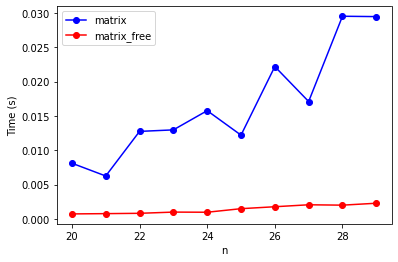

In [ ]:
plt.plot(all_n, time_matrix, 'o-', color='blue')
plt.plot(all_n, time_matrix_free, 'o-', color='red')
legend(['matrix', 'matrix_free'])
xlabel('n')
ylabel('Time (s)')

Since computing F (the right-hand side) takes too much time, to evaluate the difference in computational time between the matrix and matrix-free formulation of the problem, instead of computing F every time, I just assign a value of 1 by defualt.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add


Text(0, 0.5, 'Time (s)')

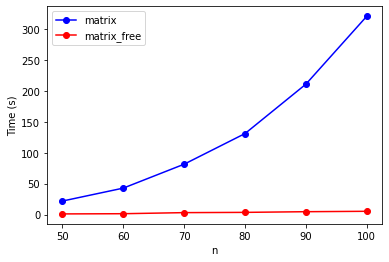

In [ ]:
time_matrix = []
time_matrix_free = []
all_n = range(50,110,10)
i=0


for n in all_n:
  q, w = np.polynomial.legendre.leggauss(n)

  AA, M, K = compute_two_dimensional_matrices(n)
  AA = AA.reshape((n**2, n**2))

  # passing a vector of just 1 as right side
  FF = np.ones(n**2, dtype=float64)

  x0 = np.zeros_like(FF)

  # matrix solution
  start_time = time.time()
  u_matrix = cg(matvec_1, FF, x0)
  time_matrix.append(time.time() - start_time)

  # free matrix solution
  st_time = time.time()
  u_free_matrix = cg(matvec_2, FF, x0)
  time_matrix_free.append(time.time() - st_time)

  #print('Iteration: ',i, '\nmat_time: ', time_matrix[i], '   mat_free_time: ',time_matrix_free[i] )
  i += 1


plt.plot(all_n, time_matrix, 'o-', color='blue')
plt.plot(all_n, time_matrix_free, 'o-', color='red')
legend(['matrix', 'matrix_free'])
xlabel('n')
ylabel('Time (s)')


In [ ]:
round(time_matrix[5],1)

320.7

In [ ]:
round(time_matrix_free[5],1)

5.2